In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [15]:
from simulation.gen_pend import *

param_dists = {
    'q': stats.uniform(-np.pi, 2 * np.pi),
    'v': stats.uniform(-1., 2),
    'b': stats.uniform(0., 0.)
}

times, trajs = gen_trajs(10_000, 5., 64, param_dists)

In [16]:
trajs.shape

(10000, 2, 64)

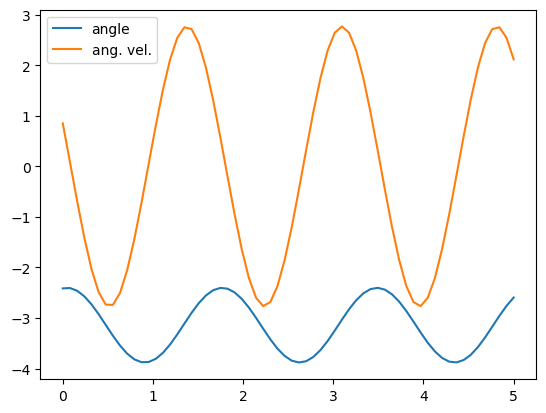

In [17]:
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

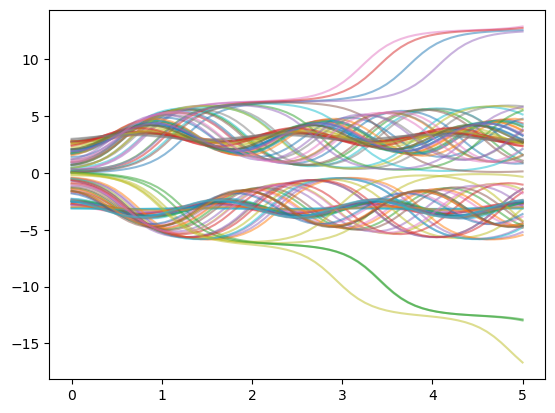

In [18]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Defining the VAE

In [19]:
# input: (bs, 2, 64)
class Encoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Encoder, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True)
        )
        self.fc_mean = nn.Linear(16 * 8, latent_dim)
        self.fc_logvar = nn.Linear(16 * 8, latent_dim)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

In [20]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 16 * 8)
        self.deconvs = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(in_channels=4, out_channels=2, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, z):
        "z: (bs, latent_dim)"
        x = self.fc(z)  # (bs, 16 * 8)
        x = x.view(x.size(0), 16, 8)
        x = self.deconvs(x)
        return x

In [21]:
def reparameterize(mean, logvar):
    "Reparameterization trick"
    std = torch.exp(0.5 * logvar)
    eps = torch.randn(logvar.shape).to(mean.device)
    return mean + eps * std

def kl_divergence(mean, logvar):
    "KL divergence between N(mean,var) and N(0,1)."
    return 0.5 * torch.sum(torch.square(mean) + torch.exp(logvar) - 1 - logvar, dim=-1)

In [22]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = reparameterize(mean, logvar)
        x_rec = self.decoder(z)
        return x_rec, mean, logvar

## Training

In [23]:
X_tr, X_val = random_split(torch.tensor(trajs), [.6, .4])
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [24]:
model = VAE(latent_dim=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)

sum(p.numel() for p in model.parameters() if p.requires_grad)

2030

In [25]:
n_epochs = 200
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # train
    model.train()
    train_loss = 0.

    for batch_idx, x in enumerate(dl_tr):
        x = x.to(device)
        x_rec, mean, logvar = model(x)
        loss = F.mse_loss(x_rec, x) + kl_divergence(mean, logvar).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * x.size(0)

    # validation
    model.eval()
    val_loss = 0.

    for batch_idx, x in enumerate(dl_val):
        x = x.to(device)
        with torch.no_grad():
            x_rec, mean, logvar = model(x)
            loss = F.mse_loss(x_rec, x) + kl_divergence(mean, logvar).mean()

        val_loss += loss.item() * x.size(0)

    train_loss /= len(dl_tr.dataset)
    val_loss /= len(dl_val.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')

Epoch [10/200], Tr Loss: 7.2634 Val Loss: 7.1943
Epoch [20/200], Tr Loss: 5.8445 Val Loss: 5.8562
Epoch [30/200], Tr Loss: 5.4639 Val Loss: 5.4047
Epoch [40/200], Tr Loss: 5.3003 Val Loss: 5.2443
Epoch [50/200], Tr Loss: 5.1994 Val Loss: 5.1040
Epoch [60/200], Tr Loss: 5.1509 Val Loss: 5.1225
Epoch [70/200], Tr Loss: 5.0878 Val Loss: 5.0248
Epoch [80/200], Tr Loss: 5.0258 Val Loss: 5.0391
Epoch [90/200], Tr Loss: 5.0195 Val Loss: 4.9464
Epoch [100/200], Tr Loss: 4.9694 Val Loss: 4.9020
Epoch [110/200], Tr Loss: 4.9697 Val Loss: 4.9079
Epoch [120/200], Tr Loss: 4.9556 Val Loss: 4.9660
Epoch [130/200], Tr Loss: 4.8883 Val Loss: 4.9279
Epoch [140/200], Tr Loss: 4.9264 Val Loss: 4.8553
Epoch [150/200], Tr Loss: 4.9324 Val Loss: 4.8900
Epoch [160/200], Tr Loss: 4.9264 Val Loss: 4.9102
Epoch [170/200], Tr Loss: 4.9224 Val Loss: 4.8847
Epoch [180/200], Tr Loss: 4.8990 Val Loss: 4.8479
Epoch [190/200], Tr Loss: 4.9049 Val Loss: 4.8059
Epoch [200/200], Tr Loss: 4.8587 Val Loss: 4.7988


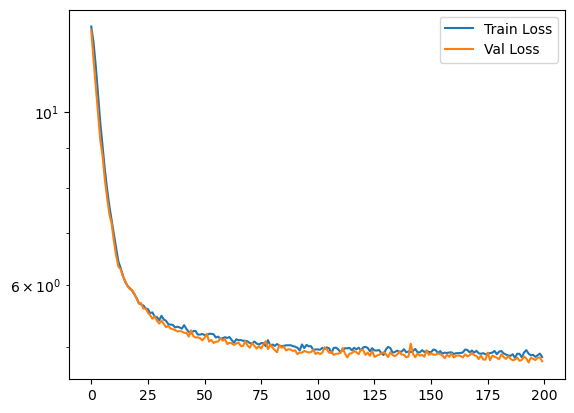

In [26]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.yscale('log')
plt.legend()

## Testing

In [ ]:
model = VAE(latent_dim=2)
model.load_state_dict(torch.load('vae.pth'))

<All keys matched successfully>

In [29]:
model.eval()
model.to('cpu');

In [323]:
save_path = 'vae.pth'
if not os.path.exists(save_path):
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to '{save_path}'")
else:
    print(f"Model already exists at '{save_path}'; not overwriting.")

Model saved to 'vae.pth'


In [30]:
with torch.no_grad():
    mean, logvar = model.encoder(torch.tensor(trajs))
latents = reparameterize(mean, logvar).numpy()

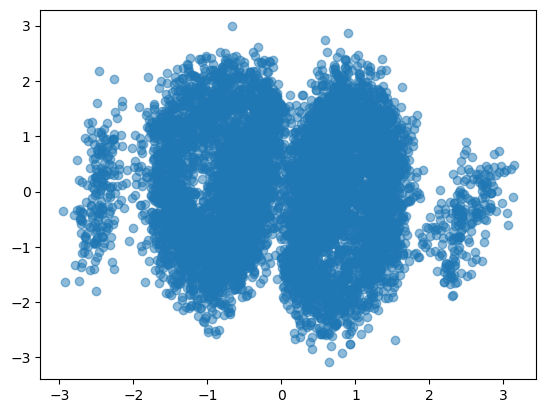

In [31]:
plt.scatter(*latents.T, alpha=0.5)

In [32]:
from latent_app import create_dash_app

app = create_dash_app(latents, trajs[:, 0])
app.run()

In [33]:
from cd_poly.cd_poly import *

In [34]:
p = CDPolynomial(latents, degree=8)
alpha = p(latents).max()

In [35]:
# an ood trajectory
_, traj_ood = gen_one_traj(5., 64, np.pi/4, 8., 0.7)

with torch.no_grad():
    _, mean_ood, logvar_ood = model(torch.tensor(traj_ood))
    latents_ood = reparameterize(mean_ood, logvar_ood).numpy()
latents_ood

array([[-0.5222007 , -0.11583425]], dtype=float32)

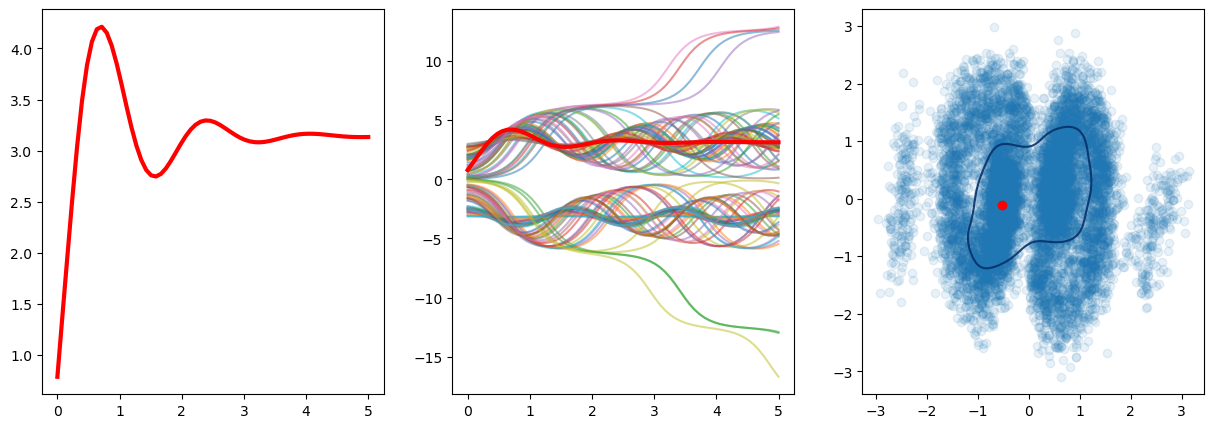

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(times, traj_ood[0, 0], color='red', lw=3)
for i in range(100):
    ax[1].plot(times, trajs[i, 0], alpha=.5)
ax[1].plot(times, traj_ood[0, 0], color='red', lw=3)
ax[2].scatter(*latents.T, alpha=.1)
ax[2].scatter(*latents_ood.T, color='red')
plot_level_set(p, alpha / 500, ax[2])

In [41]:
# a custom trajectory
amp = 1.5
freq = 10.
const = 2
custom = np.array([amp * np.sin(freq * times) + const * times, amp * freq * np.cos(freq * times) + const])

with torch.no_grad():
    _, mean_custom, logvar_custom = model(torch.tensor(custom).view(1, 2, -1))
    latents_custom = reparameterize(mean_custom, logvar_custom).numpy()
latents_custom

array([[-2.3206477 , -0.09021243]], dtype=float32)

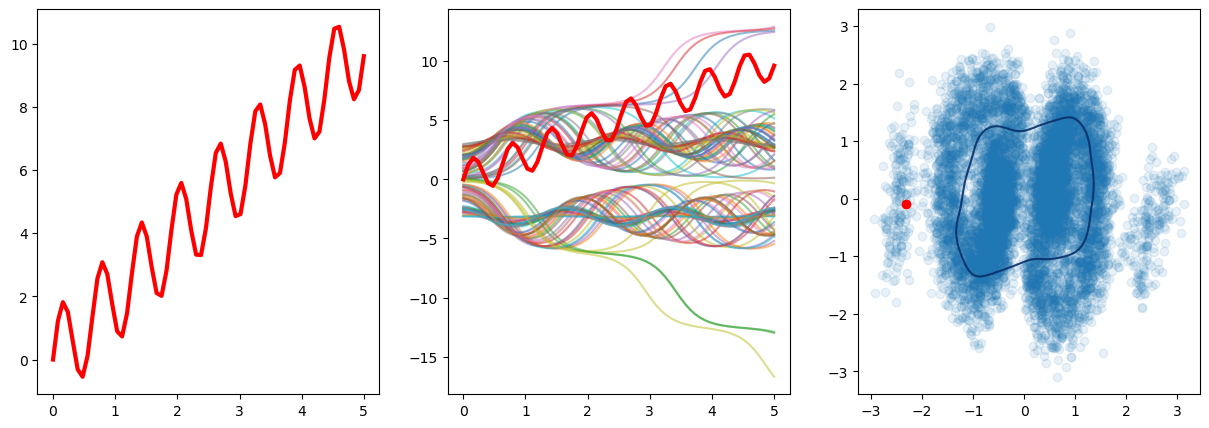

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(times, custom[0], color='red', lw=3)
for i in range(100):
    ax[1].plot(times, trajs[i, 0], alpha=.5)
ax[1].plot(times, custom[0], color='red', lw=3)
ax[2].scatter(*latents.T, alpha=.1)
ax[2].scatter(*latents_custom.T, color='red')
plot_level_set(p, alpha / 400, ax[2])

Doesn't work - some very ood trajectories are being classified as such

Interesting - with higher training loss, the latents were better at identifying ood

The feature detection isn't good - higher frequency or damped trajectories get similar outputs to regular trajectories